Reference Links:<br>
https://fanpu.io/blog/2023/score-based-diffusion-models/<br>
https://mfkasim1.github.io/2022/07/04/sgm-2/


In [2]:
# 1 sample the training data from the swiss roll distribution.
# 2 From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)
# 3 with VP SDE

In [3]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
# generate 1000 samples and add Gaussion noise with a standard deviation of 1.0 to the data
xnp, _ = make_swiss_roll(1000, noise=.2)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)
# creates a TensorDataset from the xtns tensor. This makes it easy batching and shuffling of the data.

In [4]:
len(xtns)

1000

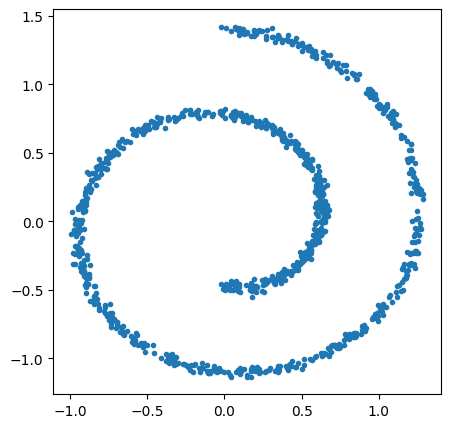

In [5]:
# show the samples
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

In [6]:
# score_network takes input of 2 + 1 (time) and returns the output of the same size (2)
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

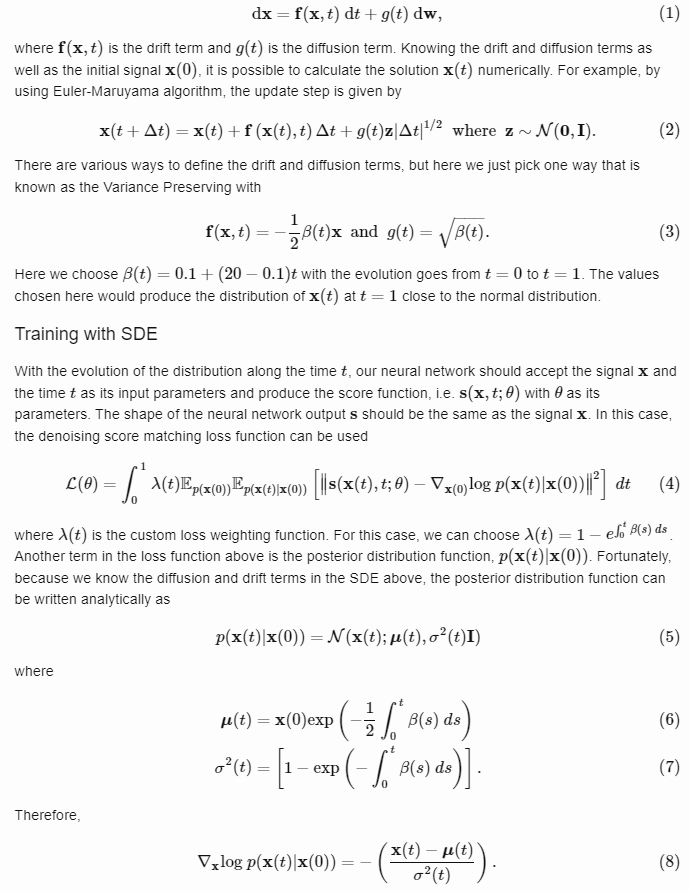

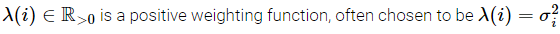

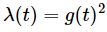

In [7]:
# define the loss function according to the above equation 4
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data

    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4
    # print(t.shape)  ==> torch.Size([256, 1])
    # print(t) ==> tensor([[0.5963],[0.5211],...,[0.4235]])

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta, (batch_size, 1)
    mu_t = x * torch.exp(-0.5 * int_beta)        # (batch_size, 2)
    var_t = -torch.expm1(-int_beta)              # (batch_size, 1)
    # torch.expm1(x) computes exp(x)-1. Therefore, -torch.expm1(-int_beta) calculates 1 - \exp(-\text{int_beta})
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, 2)

    # calculate the score function
    xt = torch.cat((x_t, t), dim=-1)  # (batch_size, 3)
    # torch.cat((x_t, t), dim=-1) is to concatenate x_t (batch_size,2) and t (batch_size,1) along the last dimension (features dimension).
    score = score_network(xt)  # score: (batch_size, 2)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)
    # torch.mean is used to approximate the continuous integral in the loss function by averaging the loss over both the data samples in a batch and the discrete time steps.

In [9]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
for i_epoch in range(50000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 5000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

0 (0.055785179138183594s): 0.20556830608844756
5000 (89.35025715827942s): 0.2081980413198471
10000 (176.35590147972107s): 0.19427986013889312
15000 (264.8257460594177s): 0.21037148201465608
20000 (357.40875148773193s): 0.20731983900070192
25000 (457.8223536014557s): 0.20469446921348572
30000 (560.3685882091522s): 0.21645642602443696
35000 (666.3237338066101s): 0.19431157064437865
40000 (772.6209752559662s): 0.17776431703567505
45000 (881.0312540531158s): 0.21196001553535462


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


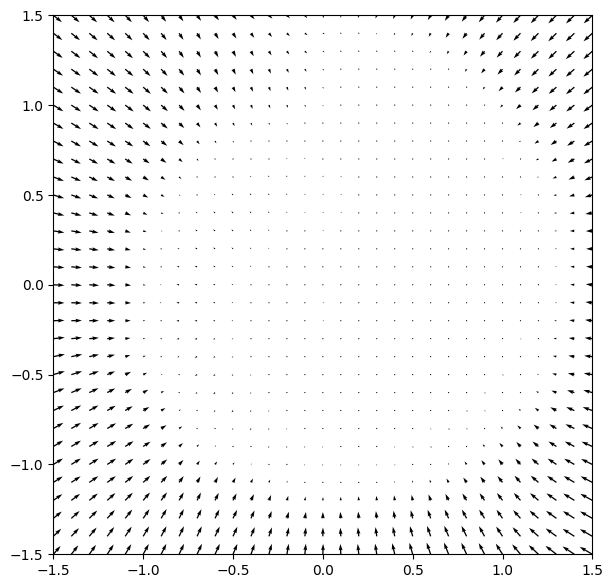

In [10]:
# display the Score function (the vector field) in the 2D space
import matplotlib.pyplot as plt

# Generate grid of input points
res = 0.1
x = torch.arange(-2, 2, res)
y = torch.arange(-2, 2, res)
xx, yy = torch.meshgrid(x, y)
x_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Set a specific time step (e.g., t = 0)
t = torch.full((x_grid.shape[0], 1), 0)

# Concatenate the grid points with the time step
xt_grid = torch.cat((x_grid, t), dim=1)

# Get score vectors on the grid at the specified time step
s_grid = score_network(xt_grid).detach()

# Plot with adjusted size and axis range
fig, ax = plt.subplots(figsize=(7, 7))  # Set the figure size
ax.quiver(x_grid[:, 0], x_grid[:, 1], s_grid[:, 0], s_grid[:, 1])
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)  # Set x-axis range
ax.set_ylim(-1.5, 1.5)  # Set y-axis range
plt.show()

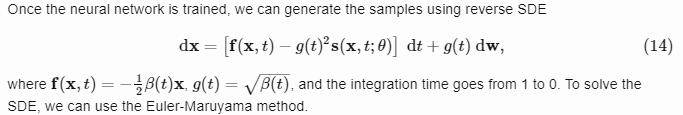

In [11]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    saved_samples = []

    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(torch.cat((x_t, t.expand(x_t.shape[0], 1)), dim=-1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5

        # Save samples every 10 steps
        if (i+2) % 10 == 0:
            saved_samples.append(x_t.clone())
    return saved_samples

In [12]:
# generate 1000 samples every 10 timesteps
saved_samples = generate_samples(score_network, 1000)

num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.